In [ ]:
  !pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.4
    Uninstalling openai-1.54.4:
      Successfully uninstalled openai-1.54.4


**Step 1: Import Libraries**

In [ ]:
import os, pandas as pd, time, openai

**Step 2: Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define input folder path
INPUT_FOLDER = "/content/drive/My Drive/mixed"

# Verify input folder
if not os.path.exists(INPUT_FOLDER):
    print(f"Error: Input folder does not exist at {INPUT_FOLDER}")
else:
    print(f"Input folder verified: {INPUT_FOLDER}")

Mounted at /content/drive
Input folder verified: /content/drive/My Drive/mixed


**Step 3: Connect to LLM API using API Key**

In [ ]:
import openai

API_KEY = "Replace with your API KEY here"  # Replace with your actual OpenAI API key

# Initialize the OpenAI client by setting the API key
openai.api_key = API_KEY

try:
    # Test connection with a simple chat prompt
    response = openai.ChatCompletion.create( # Changed to openai.ChatCompletion.create
        model="gpt-3.5-turbo",  # or "gpt-4" if you have access
        messages=[
            {"role": "user", "content": "Hello, LLM! Can you respond?"}
        ]
    )
    print(f"LLM Response: {response.choices[0].message.content.strip()}")
except Exception as e:
    print(f"Error connecting to LLM: {e}")

LLM Response: Hello! How can I assist you today?


**Step 4:Give LLM access to data and perform basic operations**

In [ ]:
def test_llm_with_data(model="gpt-3.5-turbo"):
    try:
        # Check if there are files in the input folder
        if not os.listdir(INPUT_FOLDER):
            print("No files found in the input folder.")
            return

        # Load a sample dataset
        sample_file = os.path.join(INPUT_FOLDER, os.listdir(INPUT_FOLDER)[0])
        df = pd.read_csv(sample_file, nrows=5)
        print("Sample Data (First 5 rows):")
        print(df)

        # Ask LLM to describe the dataset
        prompt = f"Analyze the following dataset:\n{df.to_string()}\nWhat can you infer?"
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "user", "content": prompt}
            ]
        )
        print("LLM Analysis Response:", response['choices'][0]['message']['content'])

    except Exception as e:
        print(f"Error during analysis: {e}")

# Call the function
test_llm_with_data()


Sample Data (First 5 rows):
   duration protocoltype service flag  srcbytes  dstbytes  land  \
0         0          tcp    smtp   SF      1239       400     0   
1         0          tcp    http   SF       222       945     0   
2         0          tcp    http   SF       235      1380     0   
3         0          tcp    http   SF       348      2029     0   
4         0          tcp    http   SF       242       380     0   

   wrongfragment  urgent  hot  ...  dsthostsamesrvrate  dsthostdiffsrvrate  \
0              0       0    0  ...                0.45                0.04   
1              0       0    0  ...                1.00                0.00   
2              0       0    0  ...                1.00                0.00   
3              0       0    0  ...                1.00                0.00   
4              0       0    0  ...                1.00                0.00   

   dsthostsamesrcportrate  dsthostsrvdiffhostrate  dsthostserrorrate  \
0                    0.00   

**Step 5: Classify Files**

In [ ]:
import os
import pandas as pd
import openai  # or replace with Google's Generative AI or another API

OUTPUT_FOLDER = "/content/drive/My Drive/classifieddata_OpenAI"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
print(f"Classifieddata folder created: {OUTPUT_FOLDER}")

def summarize_dataset(df):
    """
    Create a concise summary of the dataset to fit within token limits
    """
    # Basic dataset statistics
    summary = f"""Dataset Summary:
    - Total Rows: {len(df)}
    - Columns: {', '.join(df.columns)}

    Column Statistics:
    {df.describe().to_string()}

    Sample First 5 Rows:
    {df.head().to_string()}
    """
    return summary

def classify_and_save_files():
    try:
        INPUT_FOLDER = "/content/drive/My Drive/mixed"
        csv_files = sorted([f for f in os.listdir(INPUT_FOLDER) if f.endswith('.csv')])

        for filename in csv_files:
            file_path = os.path.join(INPUT_FOLDER, filename)

            # Use low_memory=False to handle mixed dtype columns
            df = pd.read_csv(file_path, low_memory=False)

            # Create a summarized version of the dataset
            dataset_summary = summarize_dataset(df)

            prompt = f"""Analyze this network traffic dataset summary and determine if it represents normal network behavior or if there's any suspicious/malicious activity.

            Consider these key aspects:
            - Traffic patterns and flow characteristics
            - Source and destination behaviors
            - Protocol usage and patterns
            - Any anomalous indicators

            Dataset Summary:
            {dataset_summary}

            Provide only your final classification as a single line response starting with either "Attack:" (followed by the specific type) or "Benign".
            """

            try:
                # Use OpenAI or another API (modify as needed)
                response = openai.ChatCompletion.create(
                    model="gpt-3.5-turbo",
                    messages=[
                        {"role": "system", "content": "You are a network security analyst helping to classify network traffic."},
                        {"role": "user", "content": prompt}
                    ],
                    max_tokens=150,
                    temperature=0.7
                )

                # Extract the result
                result = response['choices'][0]['message']['content'].strip()

                # Determine the new filename
                if "Attack:" in result:
                    attack_type = result.split(":")[1].strip().upper()
                    base_name, ext = os.path.splitext(filename)
                    new_filename = f"{base_name}.{attack_type}{ext}"
                else:
                    new_filename = filename

                # Save the classified file to the output folder
                new_path = os.path.join(OUTPUT_FOLDER, new_filename)
                df.to_csv(new_path, index=False)
                print(f"File {filename} classified as {result}. Saved as {new_filename}")

            except Exception as e:
                print(f"Error processing file {filename}: {e}")

    except Exception as e:
        print(f"Error in classify_and_save_files: {e}")

# Call the function
if __name__ == "__main__":
    classify_and_save_files()

Classifieddata folder created: /content/drive/My Drive/classifieddata_OpenAI
File 01.csv classified as Benign: The network traffic dataset represents normal behavior with consistent frame lengths, repetitive source and destination addresses, and uniform protocol usage.. Saved as 01.csv
File 02.csv classified as Attack: FTP-BruteForce. Saved as 02.FTP-BRUTEFORCE.csv
File 03.csv classified as Benign: The network traffic dataset represents normal network behavior.. Saved as 03.csv
File 04.csv classified as Benign: The network traffic dataset represents normal network behavior as it includes common protocols such as TCP, SMTP, and HTTP with standard flags and service types. There are no significant anomalous indicators or suspicious/malicious activities found in the dataset summary.. Saved as 04.csv
File 05.csv classified as Attack: Kernel Exploitation. Saved as 05.KERNEL EXPLOITATION.csv
File 06.csv classified as Benign. Saved as 06.csv
File 07.csv classified as Based on the provided data

**Step 6: Evaluate Results**

In [ ]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import openai

# Set your OpenAI API key


# Define paths - Update these paths according to your directory structure
GROUND_TRUTH_FOLDER = "/content/drive/My Drive/Ground"
INPUT_FOLDER = "/content/drive/My Drive/classifieddata_OpenAI"

def get_attack_type_from_filename(filename):
    """Extract attack type from filename if present."""
    parts = filename.split('.')
    if len(parts) > 2:
        return parts[1].lower()  # Assume the second part indicates the attack type
    return None

def classify_file_with_openai(file_path, model="gpt-3.5-turbo"):
    """Use OpenAI to classify a dataset."""
    try:
        # Load the first 10 rows for classification
        df = pd.read_csv(file_path, nrows=10)
        prompt = f"""Analyze the following dataset and determine if it represents normal network behavior or malicious activity.
        If malicious, specify the type of attack. Provide your classification as "Benign" or "Attack: <type>".\n\nDataset:\n{df.to_string()}"""

        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a network traffic security analyst."},
                {"role": "user", "content": prompt}
            ]
        )
        result = response['choices'][0]['message']['content'].strip()
        if "Attack:" in result:
            return True, result.split("Attack:")[1].strip().lower()
        return False, None
    except Exception as e:
        print(f"Error classifying file {file_path}: {e}")
        return None, None

def evaluate_classification():
    print("Starting evaluation...")
    try:
        # Get ground truth from filenames
        ground_truth = {}
        for filename in os.listdir(GROUND_TRUTH_FOLDER):
            if filename.endswith('.csv'):
                file_number = filename.split('.')[0]  # Get the number part
                attack_type = get_attack_type_from_filename(filename)
                ground_truth[file_number] = {
                    'is_attack': attack_type is not None,
                    'attack_type': attack_type
                }

        # Get predictions using OpenAI
        predictions = {}
        for filename in os.listdir(INPUT_FOLDER):
            if filename.endswith('.csv'):
                file_number = filename.split('.')[0]  # Get the number part
                file_path = os.path.join(INPUT_FOLDER, filename)
                is_attack, attack_type = classify_file_with_openai(file_path)
                predictions[file_number] = {
                    'is_attack': is_attack,
                    'attack_type': attack_type
                }

        # Prepare labels for metrics calculation
        true_labels = []
        pred_labels = []
        type_matches = 0
        total_attacks = 0

        # Print detailed comparison
        print("\nFile-by-file Comparison:")
        print("File\tGround Truth\tPrediction\tMatch\tAttack Type Match")
        print("-" * 70)

        for file_number in sorted(ground_truth.keys()):
            if file_number in predictions:
                true_val = ground_truth[file_number]['is_attack']
                pred_val = predictions[file_number]['is_attack']
                true_type = ground_truth[file_number]['attack_type']
                pred_type = predictions[file_number]['attack_type']

                true_labels.append(1 if true_val else 0)
                pred_labels.append(1 if pred_val else 0)

                match = "✓" if true_val == pred_val else "✗"
                type_match = "✓" if true_type == pred_type else "✗"

                if true_val:
                    total_attacks += 1
                    if true_type == pred_type:
                        type_matches += 1

                print(f"{file_number}\t{'Attack' if true_val else 'Benign'}\t"
                      f"{'Attack' if pred_val else 'Benign'}\t{match}\t{type_match}")

        # Calculate metrics
        conf_matrix = confusion_matrix(true_labels, pred_labels)
        accuracy = accuracy_score(true_labels, pred_labels)
        precision = precision_score(true_labels, pred_labels)
        recall = recall_score(true_labels, pred_labels)
        f1 = f1_score(true_labels, pred_labels)
        attack_type_accuracy = type_matches / total_attacks if total_attacks > 0 else 0

        # Print evaluation metrics
        print("\nEvaluation Metrics:")
        print("-" * 30)
        print("\nConfusion Matrix:")
        print("            Predicted")
        print("             No  Yes")
        print("Actual No   {:3d}  {:3d}".format(conf_matrix[0][0], conf_matrix[0][1]))
        print("      Yes  {:3d}  {:3d}".format(conf_matrix[1][0], conf_matrix[1][1]))

        print("\nBinary Classification Metrics:")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1 Score:  {f1:.4f}")

        print("\nAttack Type Classification:")
        print(f"Attack Type Accuracy: {attack_type_accuracy:.4f}")

        return {
            'confusion_matrix': conf_matrix,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'attack_type_accuracy': attack_type_accuracy
        }

    except Exception as e:
        print(f"Evaluation error: {e}")
        import traceback
        print(traceback.format_exc())
        return None

# Execute the evaluation
if __name__ == "__main__":
    metrics = evaluate_classification()


Starting evaluation...

File-by-file Comparison:
File	Ground Truth	Prediction	Match	Attack Type Match
----------------------------------------------------------------------
01	Attack	Benign	✗	✗
02	Attack	Benign	✗	✗
03	Benign	Benign	✓	✓
04	Benign	Benign	✓	✓
05	Attack	Attack	✓	✓
06	Benign	Benign	✓	✓
07	Benign	Benign	✓	✓
08	Attack	Attack	✓	✗
09	Attack	Attack	✓	✗
10	Benign	Benign	✓	✓
11	Benign	Benign	✓	✓
12	Attack	Attack	✓	✗
13	Attack	Benign	✗	✗
14	Attack	Benign	✗	✗
15	Benign	Benign	✓	✓
16	Benign	Benign	✓	✓
17	Benign	Benign	✓	✓
18	Benign	Benign	✓	✓
19	Benign	Benign	✓	✓
20	Benign	Benign	✓	✓
21	Attack	Attack	✓	✗
22	Attack	Attack	✓	✗
23	Attack	Attack	✓	✗
24	Attack	Attack	✓	✓

Evaluation Metrics:
------------------------------

Confusion Matrix:
            Predicted
             No  Yes
Actual No    12    0
      Yes    4    8

Binary Classification Metrics:
Accuracy:  0.8333
Precision: 1.0000
Recall:    0.6667
F1 Score:  0.8000

Attack Type Classification:
Attack Type Accuracy: 0.1667


**Step 6: Evaluate Results with graphs **

In [ ]:
pip install matplotlib seaborn numpy pandas scikit-learn

Starting evaluation...

File-by-file Comparison:
File	Ground Truth	Prediction	Match	Attack Type Match
----------------------------------------------------------------------
01	Attack	Benign	✗	✗
02	Attack	Attack	✓	✗
03	Benign	Benign	✓	✓
04	Benign	Benign	✓	✓
05	Attack	Attack	✓	✗
06	Benign	Benign	✓	✓
07	Benign	Benign	✓	✓
08	Attack	Attack	✓	✗
09	Attack	Attack	✓	✗
10	Benign	Benign	✓	✓
11	Benign	Benign	✓	✓
12	Attack	Attack	✓	✗
13	Attack	Attack	✓	✗
14	Attack	Benign	✗	✗
15	Benign	Benign	✓	✓
16	Benign	Benign	✓	✓
17	Benign	Benign	✓	✓
18	Benign	Benign	✓	✓
19	Benign	Benign	✓	✓
20	Benign	Benign	✓	✓
21	Attack	Attack	✓	✗
22	Attack	Attack	✓	✗
23	Attack	Attack	✓	✗
24	Attack	Attack	✓	✓

Evaluation Metrics:
------------------------------

Confusion Matrix:
            Predicted
             No  Yes
Actual No    12    0
      Yes    2   10

Binary Classification Metrics:
Accuracy:  0.9167
Precision: 1.0000
Recall:    0.8333
F1 Score:  0.9091
Attack Type Accuracy: 0.0833


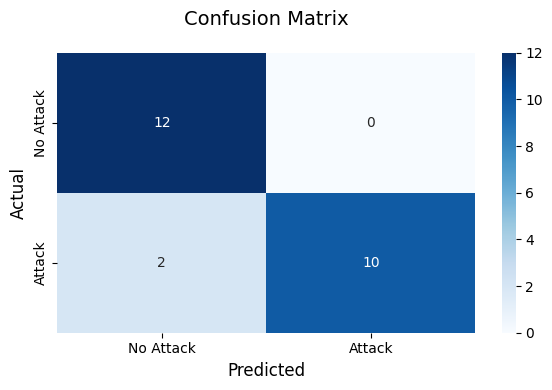

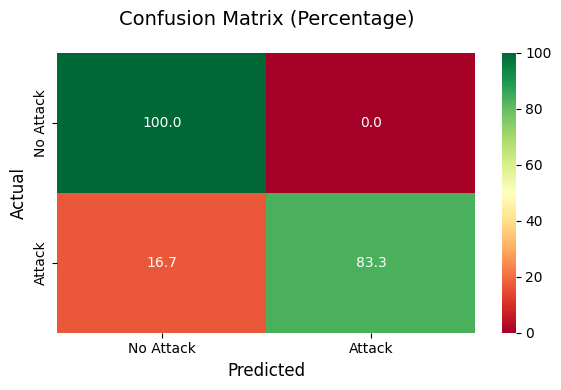

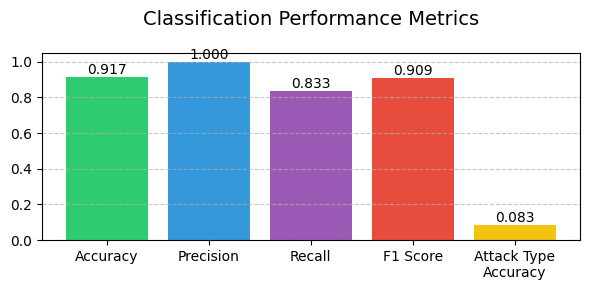

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import openai



GROUND_TRUTH_FOLDER = "/content/drive/My Drive/Ground"
INPUT_FOLDER = "/content/drive/My Drive/classifieddata_OpenAI"

def get_attack_type_from_filename(filename):
    """Extract attack type from filename if present"""
    parts = filename.split('.')
    if len(parts) > 2:
        return parts[1].lower()
    return None

def classify_file_with_openai(file_path, model="gpt-3.5-turbo"):
    """Use OpenAI to classify a dataset"""
    try:
        df = pd.read_csv(file_path, nrows=10)
        prompt = f"""Analyze the following dataset and determine if it represents normal network behavior or malicious activity.
        If malicious, specify the type of attack. Provide your classification as "Benign" or "Attack: <type>".\n\nDataset:\n{df.to_string()}"""

        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a network traffic security analyst."},
                {"role": "user", "content": prompt}
            ]
        )
        result = response['choices'][0]['message']['content'].strip()
        if "Attack:" in result:
            return True, result.split("Attack:")[1].strip().lower()
        return False, None
    except Exception as e:
        print(f"Error classifying file {file_path}: {e}")
        return None, None

def plot_confusion_matrix_heatmap(conf_matrix):
    """Plot confusion matrix as a heatmap"""
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['No Attack', 'Attack'],
                yticklabels=['No Attack', 'Attack'])
    plt.title('Confusion Matrix', pad=20, size=14)
    plt.ylabel('Actual', size=12)
    plt.xlabel('Predicted', size=12)
    plt.tight_layout()
    plt.show()

def plot_metrics_bar(metrics_dict):
    """Plot performance metrics as a bar chart"""
    metrics_to_plot = {
        'Accuracy': metrics_dict['accuracy'],
        'Precision': metrics_dict['precision'],
        'Recall': metrics_dict['recall'],
        'F1 Score': metrics_dict['f1_score'],
        'Attack Type\nAccuracy': metrics_dict['attack_type_accuracy']
    }
    plt.figure(figsize=(6, 3))
    bars = plt.bar(metrics_to_plot.keys(), metrics_to_plot.values(), color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f1c40f'])
    plt.title('Classification Performance Metrics', pad=20, size=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.3f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

def plot_percentage_matrix(conf_matrix):
    """Plot confusion matrix as percentages"""
    plt.figure(figsize=(6, 4))
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(conf_matrix_percent, annot=True, fmt='.1f', cmap='RdYlGn',
                xticklabels=['No Attack', 'Attack'],
                yticklabels=['No Attack', 'Attack'])
    plt.title('Confusion Matrix (Percentage)', pad=20, size=14)
    plt.ylabel('Actual', size=12)
    plt.xlabel('Predicted', size=12)
    plt.tight_layout()
    plt.show()

def evaluate_classification():
    print("Starting evaluation...")
    try:
        ground_truth = {}
        for filename in os.listdir(GROUND_TRUTH_FOLDER):
            if filename.endswith('.csv'):
                file_number = filename.split('.')[0]
                attack_type = get_attack_type_from_filename(filename)
                ground_truth[file_number] = {
                    'is_attack': attack_type is not None,
                    'attack_type': attack_type
                }

        predictions = {}
        for filename in os.listdir(INPUT_FOLDER):
            if filename.endswith('.csv'):
                file_number = filename.split('.')[0]
                file_path = os.path.join(INPUT_FOLDER, filename)
                is_attack, attack_type = classify_file_with_openai(file_path)
                predictions[file_number] = {
                    'is_attack': is_attack,
                    'attack_type': attack_type
                }

        true_labels = []
        pred_labels = []
        type_matches = 0
        total_attacks = 0

        print("\nFile-by-file Comparison:")
        print("File\tGround Truth\tPrediction\tMatch\tAttack Type Match")
        print("-" * 70)

        for file_number in sorted(ground_truth.keys()):
            if file_number in predictions:
                true_val = ground_truth[file_number]['is_attack']
                pred_val = predictions[file_number]['is_attack']
                true_type = ground_truth[file_number]['attack_type']
                pred_type = predictions[file_number]['attack_type']

                true_labels.append(1 if true_val else 0)
                pred_labels.append(1 if pred_val else 0)

                match = "✓" if true_val == pred_val else "✗"
                type_match = "✓" if true_type == pred_type else "✗"

                if true_val:
                    total_attacks += 1
                    if true_type == pred_type:
                        type_matches += 1

                print(f"{file_number}\t{'Attack' if true_val else 'Benign'}\t"
                      f"{'Attack' if pred_val else 'Benign'}\t{match}\t{type_match}")

        conf_matrix = confusion_matrix(true_labels, pred_labels)
        accuracy = accuracy_score(true_labels, pred_labels)
        precision = precision_score(true_labels, pred_labels)
        recall = recall_score(true_labels, pred_labels)
        f1 = f1_score(true_labels, pred_labels)
        attack_type_accuracy = type_matches / total_attacks if total_attacks > 0 else 0

        print("\nEvaluation Metrics:")
        print("-" * 30)
        print("\nConfusion Matrix:")
        print("            Predicted")
        print("             No  Yes")
        print("Actual No   {:3d}  {:3d}".format(conf_matrix[0][0], conf_matrix[0][1]))
        print("      Yes  {:3d}  {:3d}".format(conf_matrix[1][0], conf_matrix[1][1]))

        print("\nBinary Classification Metrics:")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"Attack Type Accuracy: {attack_type_accuracy:.4f}")

        metrics_dict = {
            'confusion_matrix': conf_matrix,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'attack_type_accuracy': attack_type_accuracy
        }

        plot_confusion_matrix_heatmap(conf_matrix)
        plot_percentage_matrix(conf_matrix)
        plot_metrics_bar(metrics_dict)

        return metrics_dict

    except Exception as e:
        print(f"Evaluation error: {e}")
        return None

if __name__ == "__main__":
    metrics = evaluate_classification()
